In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import shap

from lightgbm import LGBMClassifier

from catalyst.data_prep.handle_missing_vals import fill_missing_vals
from catalyst.ml.analysis.feat_impt import permutation_importance, plot_feature_importance

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
def metric_lgb_auc(model, X_val: pd.DataFrame, y_val: pd.DataFrame) -> float:
    """
    Returns the AUC score based on the model, X_val, and y_val.

    Args:
        model: Fitted machine learning model (e.g., sklearn, xgb, lgb) to be used for prediction
        X_val: Validation data with feature columns.
        y_val: Validation labels.

    Returns:
        AUC score
    """
    pred_proba = model.predict_proba(X_val)
    return roc_auc_score(y_val, pred_proba[:, 1])

In [3]:
df = pd.read_csv('widsdatathon2020/training_v2.csv', dtype={'apache_2_diagnosis': str,
                                                            'apache_3j_diagnosis': str,
                                                           'icu_id': str})
test = pd.read_csv('widsdatathon2020/unlabeled.csv', dtype={'apache_2_diagnosis': str,
                                                            'apache_3j_diagnosis': str,
                                                           'icu_id': str})

In [4]:
na_vals = {'str_na_value': 'NA_VALUE',
'int_na_value': -1,
'float_na_value': -1.0}

df = fill_missing_vals(df, **na_vals)
test = fill_missing_vals(test, **na_vals)

In [5]:
# Break down diagnosis codes!
def break_down_diagnosis_codes(df):
    df['apache_2_diagnosis_group'] = df.apache_2_diagnosis.str[0]
    df['apache_3j_diagnosis_subgroup'] = df.apache_3j_diagnosis.apply(lambda x: x.split(".")[0])
    df['apache_3j_diagnosis_group'] = df.apache_3j_diagnosis.str[0]
    return df

In [6]:
df['apache_comorbidity_count'] = df[['aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression',
   'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']].replace(-1, 0).sum(axis=1)
test['apache_comorbidity_count'] = test[['aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression',
   'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']].replace(-1, 0).sum(axis=1)

In [7]:
df = break_down_diagnosis_codes(df)
test = break_down_diagnosis_codes(test)

In [8]:
df['glasgow_scale'] = np.where(df['gcs_unable_apache'] == 0,
                               df[['gcs_verbal_apache', 'gcs_eyes_apache', 'gcs_motor_apache']].sum(axis=1),
                               -1)
test['glasgow_scale'] = np.where(test['gcs_unable_apache'] == 0,
                               test[['gcs_verbal_apache', 'gcs_eyes_apache', 'gcs_motor_apache']].sum(axis=1),
                               -1)

In [9]:
def get_vitals_h1_d1(df):
    # Check if h1 is the min/max of the day (d1)
    metric_rename = {'_min': '_issmallest',
                '_max': '_islargest'}

    for col in df.columns:
        for metric in ['_min', '_max']:
            if 'h1' in col and metric in col:
                d1_col = col.replace('h1', 'd1')
                is_col = col.replace(metric, metric_rename[metric])
                df[is_col] = np.where(((df[col] != -1) & (df[col] == df[d1_col])), 1, 0)

    return df

In [10]:
def get_vitals_diff(df):
    for col in df.columns:
        if '_min' in col:
            max_col = col.replace('_min', '_max')
            diff_col = col.replace('_min', '_minmax_diff')
            df[diff_col] = df[max_col] - df[col]
    return df

In [11]:
df = get_vitals_h1_d1(df)
test = get_vitals_h1_d1(test)

df = get_vitals_diff(df)
test = get_vitals_diff(test)

In [12]:
death_prob_icu = df.groupby(['d1_bun_minmax_diff']).hospital_death.value_counts(normalize=True)
death_prob_icu = death_prob_icu.rename('chance')
death_prob_icu = death_prob_icu.reset_index()

In [44]:
df.icu_admit_source.value_counts()

Accident & Emergency         54060
Operating Room / Recovery    18713
Floor                        15611
Other Hospital                2358
Other ICU                      859
NA_VALUE                       112
Name: icu_admit_source, dtype: int64

In [45]:
death_prob_icu = train.groupby(['icu_id']).hospital_death.value_counts(normalize=True)
death_prob_icu = death_prob_icu.rename('chance')
death_prob_icu = death_prob_icu.reset_index()

NameError: name 'train' is not defined

In [402]:
death_prob_icu[death_prob_icu.hospital_death == 1].sort_values('chance')

,icu_id,hospital_death,chance
421,874,1,0.007042
69,174,1,0.008065
7,87,1,0.010417
13,91,1,0.023904
453,921,1,0.024155
...,...,...,...
265,547,1,0.222222
258,531,1,0.250000
362,698,1,0.319588
286,603,1,0.500000


In [13]:
admit_source_order = {'Other': 1,
                      'Step-Down Unit (SDU)': 2,
                     'Other ICU': 3,
                     'Floor': 4,
                     'Other Hospital': 4,
                     'Acute Care/Floor': 5,
                     'Direct Admit': 5,
                     'Emergency Department': 6,
                     'ICU': 7,
                     'NA_VALUE': -1,
                     'ICU to SDU': 9,
                     'Chest Pain Center': 8,
                     'Recovery Room': 10,
                     'Operating Room': 10,
                     'PACU': 10,
                     'Observation': 11}

In [14]:
icu_order = {'MICU': 1,
            'Cardiac ICU': 2,
            'Med-Surg ICU': 3,
            'Neuro ICU': 3,
            'CCU-CTICU': 4,
            'SICU': 4,
            'CTICU': 5,
            'CSICU': 6}

In [15]:
df.icu_type = df.icu_type.replace(icu_order)
df.hospital_admit_source = df.hospital_admit_source.replace(admit_source_order)

test.icu_type = test.icu_type.replace(icu_order)
test.hospital_admit_source = test.hospital_admit_source.replace(admit_source_order)

In [16]:
df = df[df.hospital_admit_source != 11]
df.drop(columns=['encounter_id', 'patient_id'], inplace=True)
test.drop(columns=['encounter_id', 'patient_id'], inplace=True)

### train_val_split

In [174]:
# xdf = df.drop(columns=['hospital_death'])
# ydf = df[['hospital_death']]

In [175]:
# X_train, X_val, y_train, y_val = train_test_split(xdf, ydf, test_size=0.2, random_state=21)

In [7]:
y_train.hospital_death.value_counts(normalize=True)

0    0.913943
1    0.086057
Name: hospital_death, dtype: float64

In [8]:
y_val.hospital_death.value_counts(normalize=True)

0    0.912719
1    0.087281
Name: hospital_death, dtype: float64

In [17]:
train, val = train_test_split(df, test_size=0.2, random_state=21)

In [29]:
train.to_csv('widsdatathon2020/train.csv', index=False)
val.to_csv('widsdatathon2020/val.csv', index=False)

### feat encoding

In [18]:
from catalyst.feat_eng.encoder.label import fit_label, transform_label

In [19]:
encoding_cols = list(train.select_dtypes(include='object').columns)

In [20]:
encoding_cols

['ethnicity',
 'gender',
 'icu_admit_source',
 'icu_id',
 'icu_stay_type',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'apache_3j_bodysystem',
 'apache_2_bodysystem',
 'apache_2_diagnosis_group',
 'apache_3j_diagnosis_subgroup',
 'apache_3j_diagnosis_group']

In [21]:
encoder = fit_label(train, cols=encoding_cols)
train_encoded = transform_label(train, encoder)
val_encoded = transform_label(val, encoder)

In [213]:
train_encoded.to_csv('widsdatathon2020/train_encoded.csv', index=False)
val_encoded.to_csv('widsdatathon2020/val_encoded.csv', index=False)

#### run benchmarks

In [22]:
from catalyst.ml.experiment.benchmark import binary_cv, binary

In [23]:
train_encoded = train_encoded.reset_index(drop=True)
X_train = train_encoded.drop(columns=['hospital_death', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'])
y_train = train_encoded[['hospital_death']]

val_encoded = val_encoded.reset_index(drop=True)
X_val = val_encoded.drop(columns=['hospital_death', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'])
y_val = val_encoded[['hospital_death']]

In [74]:
binary(X_train, y_train['hospital_death'], X_val, y_val['hospital_death'], plot=False)

,model_name,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score,pr_auc_score
10,XGBoost,0.929455,0.363523,0.679113,0.473556,0.894233,0.558868
11,LightGBM,0.930491,0.347283,0.707379,0.465857,0.900521,0.578736
8,GradientBoostingClassifier,0.929564,0.320425,0.715481,0.442623,0.894084,0.561404
5,AdaBoostClassifier,0.925530,0.324172,0.646326,0.431780,0.884838,0.519938
9,RandomForestClassifier,0.927275,0.264834,0.729776,0.388634,0.883992,0.537845
6,BaggingClassifier,0.922804,0.267333,0.637854,0.376761,0.829124,0.470432
4,DecisionTreeClassifier,0.879954,0.362898,0.329552,0.345422,0.646149,0.374029
7,ExtraTreesClassifier,0.926675,0.217989,0.789593,0.341654,0.881831,0.535659
2,GaussianNB,0.804503,0.557776,0.236807,0.332465,0.787622,0.327253
1,RidgeClassifier,0.923131,0.163023,0.788520,0.270186,NaN,NaN


#### K-fold Cross Val

In [24]:
from catalyst.ml.model.ligthgbm_model import LGBModel

In [25]:
from sklearn.model_selection import KFold

In [85]:
# KFOLD X VAL
encoder = fit_label(df, cols=encoding_cols)
df_encoded = transform_label(df, encoder)

df_encoded = df_encoded.reset_index(drop=True)
xdf = df_encoded.drop(columns=['hospital_death', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'])
xdf.hospital_admit_source = xdf.hospital_admit_source.replace(-1, 0)
ydf = df_encoded[['hospital_death']]

# kf = KFold(n_splits=5)
# aucs = []
# for train_index, test_index in kf.split(xdf):
#     X_train_cv, X_val_cv = xdf.iloc[train_index], xdf.iloc[test_index]
#     y_train_cv, y_val_cv = ydf.iloc[train_index], ydf.iloc[test_index]
    
# #     model = LGBMClassifier(class_weight='balanced', objective='binary', n_estimators=100)
#     model = LGBModel('LightGBMBinary', 'binary', **best_params)

#     model.fit(X_train_cv[features], y_train_cv['hospital_death'])
#     pred_proba = model.predict_proba(X_val_cv[features])
    
# #     auc = roc_auc_score(y_val_cv, pred_proba[:,1])
#     auc = roc_auc_score(y_val_cv, pred_proba)

#     print(auc)
#     aucs.append(auc)
    
# print(np.mean(aucs))

#### Param tuning

In [26]:
from catalyst.ml.experiment.tuning import binary

import ray
from ray.tune import run
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest.hyperopt import HyperOptSearch

from hyperopt import hp
from hyperopt.pyll.base import scope

In [574]:
binary(X_train, y_train, X_val, y_val, model_name= 'LightGBM')

100%|██████████| 100/100 [27:31<00:00, 16.51s/trial, best loss: 0.3520528744017721]


,bagging_fraction,bagging_freq,boosting,eta,feature_fraction,max_depth,min_data_in_leaf,min_gain_to_split,num_boost_round,num_leaves,loss_value
4,1.0,2,dart,0.52,0.7,36,76,1,900,640,0.911445
11,0.9,2,gbdt,0.02,0.6,14,10,0,400,80,0.911402
48,0.8,4,gbdt,0.01,1.0,13,54,2,700,5120,0.910752
15,0.8,5,dart,0.25,0.7,15,88,2,900,320,0.909448
54,0.6,2,dart,0.07,0.6,34,33,2,300,5120,0.908634
...,...,...,...,...,...,...,...,...,...,...,...
82,0.6,2,dart,0.87,0.7,14,52,1,700,40,0.456729
24,0.6,3,dart,0.85,0.5,24,42,2,400,1280,0.428871
28,0.5,1,dart,0.86,0.5,11,68,2,400,5120,0.371174
75,0.6,2,dart,1.01,0.7,20,34,1,700,160,0.357175


In [88]:
def train_val(config):
    
    kf = KFold(n_splits=5)
    aucs = []
    for train_index, test_index in kf.split(xdf):
        X_train_cv, X_val_cv = xdf.iloc[train_index], xdf.iloc[test_index]
        y_train_cv, y_val_cv = ydf.iloc[train_index], ydf.iloc[test_index]

#         model = LGBMClassifier(class_weight='balanced', objective='binary', n_estimators=100)
        model = LGBModel('LightGBMBinary', 'binary', **config)

        model.fit(X_train_cv, y_train_cv['hospital_death'])
        pred_proba = model.predict_proba(X_val_cv)

    #     auc = roc_auc_score(y_val_cv, pred_proba[:,1])
        auc = roc_auc_score(y_val_cv, pred_proba)

        print(auc)
        aucs.append(auc)

    auc = np.mean(aucs)
    
#     model = LGBModel('LightGBMBinary', 'binary', **config)
#     model.fit(X_train, y_train)
#     pred = model.predict(X_val)
#     pred_proba = model.predict_proba(X_val)
#     pred_train = model.predict(X_train)
#     pred_proba_train = model.predict_proba(X_train)
    
    ray.tune.track.log(
        auc=auc,
        done=True)

In [42]:
model = LGBModel('LightGBMBinary', 'binary', **config['config'])

In [43]:
model.fit(X_train, y_train)

In [44]:
pred = model.predict(X_val)
pred_proba = model.predict_proba(X_val)
pred_train = model.predict(X_train)
pred_proba_train = model.predict_proba(X_train)

In [45]:
accuracy=accuracy_score(y_val, pred)
auc=roc_auc_score(y_val, pred_proba)
accuracy_train = accuracy_score(y_train, pred_train)
auc_train=roc_auc_score(y_train, pred_proba_train)

In [51]:
X_val

,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,...,h1_sodium_minmax_diff,h1_wbc_minmax_diff,d1_arterial_pco2_minmax_diff,d1_arterial_ph_minmax_diff,d1_arterial_po2_minmax_diff,d1_pao2fio2ratio_minmax_diff,h1_arterial_pco2_minmax_diff,h1_arterial_ph_minmax_diff,h1_arterial_po2_minmax_diff,h1_pao2fio2ratio_minmax_diff
0,161,27.0,23.624447,0,1,2,162.00,-1,1,62,...,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.00,0.0,0.0
1,112,89.0,31.057487,0,1,1,177.00,6,1,68,...,0.0,0.0,15.0,0.03,131.0,25.714286,0.0,0.01,14.0,20.0
2,117,57.0,27.624515,0,1,2,172.72,10,3,131,...,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.00,0.0,0.0
3,83,73.0,27.221356,1,1,2,165.10,10,3,41,...,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.00,0.0,0.0
4,188,29.0,25.662064,0,1,1,188.00,6,1,40,...,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18336,195,77.0,21.901819,0,2,2,165.10,6,1,138,...,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.00,0.0,0.0
18337,54,60.0,26.655231,0,2,1,172.70,-1,6,22,...,0.0,0.0,16.0,0.06,339.0,207.000000,0.0,0.00,0.0,0.0
18338,26,24.0,17.457237,0,5,2,142.20,6,1,223,...,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.00,0.0,0.0
18339,33,50.0,29.551070,1,1,2,156.20,10,3,72,...,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.00,0.0,0.0


In [92]:
space = {'learning_rate': hp.quniform('learning_rate', 0.02, 0.1, 0.01),
        'num_leaves': scope.int(hp.quniform('num_leaves', 100, 800, 20)),
#         'max_depth': scope.int(hp.choice('max_depth', [9, 10, 11, 12, 13])),
#         'min_child_samples': scope.int(hp.quniform('min_child_samples', 20, 50, 1)),
        'min_data_in_leaf': scope.int(hp.quniform('min_data_in_leaf', 20, 100, 2)),
        'bagging_fraction': hp.quniform('bagging_fraction', 0.8, 0.9, 0.01),
# #         'bagging_freq': scope.int(hp.choice('bagging_freq', [0, 1, 2, 3, 4, 5])),
        'feature_fraction': hp.quniform('feature_fraction', 0.8, 0.9, 0.01),
#         'min_split_gain': scope.int(hp.choice('min_split_gain', [0, 1, 2]))
         'num_boost_round': scope.int(hp.quniform('num_boost_round', 800, 1500, 100)),
        }

current_best_params = [
                        {'learning_rate': 0.05,
#                          'max_depth': 2,
#                          'min_child_samples': 20,
#                          'min_split_gain': 0,
                         'num_boost_round': 900,
                         'num_leaves': 600,
                         'min_data_in_leaf': 70,
                        'bagging_fraction': 1,
                        'feature_fraction': 0.88}
                    ]

config = {
    "num_samples": 10,
    "config": {
        'seed': 42,
        'metric': 'auc'
    },
    "stop": {
        "timesteps_total": 2
        
    },
}

algo = HyperOptSearch(
    space,
    metric="auc",
    mode="max",
    points_to_evaluate=current_best_params
    )

scheduler = AsyncHyperBandScheduler(metric="auc", mode="max")

In [ ]:
obj = run(train_val, search_alg=algo, scheduler=scheduler, **config)

2020-01-17 17:18:20,914	INFO function_runner.py:254 -- tune.track signature detected.
2020-01-17 17:18:41,913	WARNING logger.py:413 -- Could not instantiate tf2_compat_logger: No module named 'tensorflow'.
2020-01-17 17:18:43,429	INFO ray_trial_executor.py:121 -- Trial train_val_4e7b23ac: Setting up new remote runner.
2020-01-17 17:18:43,677	WARNING worker.py:1054 -- Warning: The actor WrappedTrackFunc has size 231106602 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2020-01-17 17:18:43,996	WARNING util.py:140 -- The `start_trial` operation took 2.0858631134033203 seconds to complete, which may be a performance bottleneck.


Trial name,status,loc,num_boost_round,min_data_in_leaf,num_leaves,learning_rate,feature_fraction,bagging_fraction
train_val_4e7b23ac,RUNNING,,,,,,,
train_val_4fb8b068,PENDING,,,,,,,
train_val_510c753a,PENDING,,,,,,,
train_val_524d1e18,PENDING,,,,,,,
train_val_53a34e86,PENDING,,,,,,,
train_val_54cc8692,PENDING,,,,,,,
train_val_55f253b2,PENDING,,,,,,,
train_val_5716d01a,PENDING,,,,,,,
train_val_583a6fa6,PENDING,,,,,,,
train_val_595ccc3a,PENDING,,,,,,,


2020-01-17 17:18:44,138	WARNING logger.py:413 -- Could not instantiate tf2_compat_logger: No module named 'tensorflow'.
2020-01-17 17:18:45,690	INFO ray_trial_executor.py:121 -- Trial train_val_4fb8b068: Setting up new remote runner.
2020-01-17 17:18:45,985	WARNING worker.py:1054 -- Warning: The actor WrappedTrackFunc has size 231106602 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2020-01-17 17:18:46,322	WARNING util.py:140 -- The `start_trial` operation took 2.1859750747680664 seconds to complete, which may be a performance bottleneck.
2020-01-17 17:18:46,468	WARNING logger.py:413 -- Could not instantiate tf2_compat_logger: No module named 'tensorflow'.
2020-01-17 17:18:48,376	INFO ray_trial_executor.py:121 -- Trial train_val_510c753a: Setting up new remote runner.
2020-01-17 17:18:48,743	WARNING worker.py:1054 -- Warning: The actor WrappedTrackFunc has size 231106602 when pickled. It w

Trial name,status,loc,num_boost_round,min_data_in_leaf,num_leaves,learning_rate,feature_fraction,bagging_fraction
train_val_4e7b23ac,RUNNING,,,,,,,
train_val_4fb8b068,RUNNING,,,,,,,
train_val_510c753a,RUNNING,,,,,,,
train_val_524d1e18,PENDING,,,,,,,
train_val_53a34e86,PENDING,,,,,,,
train_val_54cc8692,PENDING,,,,,,,
train_val_55f253b2,PENDING,,,,,,,
train_val_5716d01a,PENDING,,,,,,,
train_val_583a6fa6,PENDING,,,,,,,
train_val_595ccc3a,PENDING,,,,,,,


2020-01-17 17:18:49,432	WARNING logger.py:413 -- Could not instantiate tf2_compat_logger: No module named 'tensorflow'.
2020-01-17 17:18:51,856	INFO ray_trial_executor.py:121 -- Trial train_val_524d1e18: Setting up new remote runner.
2020-01-17 17:18:52,275	WARNING worker.py:1054 -- Warning: The actor WrappedTrackFunc has size 231106602 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2020-01-17 17:18:52,910	WARNING util.py:140 -- The `start_trial` operation took 3.4819257259368896 seconds to complete, which may be a performance bottleneck.
2020-01-17 17:18:53,113	WARNING logger.py:413 -- Could not instantiate tf2_compat_logger: No module named 'tensorflow'.
2020-01-17 17:18:55,591	INFO ray_trial_executor.py:121 -- Trial train_val_53a34e86: Setting up new remote runner.
2020-01-17 17:18:55,996	WARNING worker.py:1054 -- Warning: The actor WrappedTrackFunc has size 231106602 when pickled. It w

Trial name,status,loc,num_boost_round,min_data_in_leaf,num_leaves,learning_rate,feature_fraction,bagging_fraction
train_val_4e7b23ac,RUNNING,,,,,,,
train_val_4fb8b068,RUNNING,,,,,,,
train_val_510c753a,RUNNING,,,,,,,
train_val_524d1e18,RUNNING,,,,,,,
train_val_53a34e86,RUNNING,,,,,,,
train_val_54cc8692,PENDING,,,,,,,
train_val_55f253b2,PENDING,,,,,,,
train_val_5716d01a,PENDING,,,,,,,
train_val_583a6fa6,PENDING,,,,,,,
train_val_595ccc3a,PENDING,,,,,,,


2020-01-17 17:18:56,505	WARNING logger.py:413 -- Could not instantiate tf2_compat_logger: No module named 'tensorflow'.
2020-01-17 17:18:58,862	INFO ray_trial_executor.py:121 -- Trial train_val_54cc8692: Setting up new remote runner.
2020-01-17 17:18:59,382	WARNING worker.py:1054 -- Warning: The actor WrappedTrackFunc has size 231106602 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2020-01-17 17:19:00,151	WARNING util.py:140 -- The `start_trial` operation took 3.648646831512451 seconds to complete, which may be a performance bottleneck.
2020-01-17 17:19:00,161	WARNING logger.py:413 -- Could not instantiate tf2_compat_logger: No module named 'tensorflow'.
2020-01-17 17:19:02,440	INFO ray_trial_executor.py:121 -- Trial train_val_55f253b2: Setting up new remote runner.
2020-01-17 17:19:02,777	WARNING worker.py:1054 -- Warning: The actor WrappedTrackFunc has size 231106602 when pickled. It wi

Trial name,status,loc,num_boost_round,min_data_in_leaf,num_leaves,learning_rate,feature_fraction,bagging_fraction
train_val_4e7b23ac,RUNNING,,,,,,,
train_val_4fb8b068,RUNNING,,,,,,,
train_val_510c753a,RUNNING,,,,,,,
train_val_524d1e18,RUNNING,,,,,,,
train_val_53a34e86,RUNNING,,,,,,,
train_val_54cc8692,RUNNING,,,,,,,
train_val_55f253b2,RUNNING,,,,,,,
train_val_5716d01a,PENDING,,,,,,,
train_val_583a6fa6,PENDING,,,,,,,
train_val_595ccc3a,PENDING,,,,,,,


2020-01-17 17:19:03,315	WARNING logger.py:413 -- Could not instantiate tf2_compat_logger: No module named 'tensorflow'.
2020-01-17 17:19:05,534	INFO ray_trial_executor.py:121 -- Trial train_val_5716d01a: Setting up new remote runner.
2020-01-17 17:19:05,932	WARNING worker.py:1054 -- Warning: The actor WrappedTrackFunc has size 231106602 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2020-01-17 17:19:06,527	WARNING util.py:140 -- The `start_trial` operation took 3.215280771255493 seconds to complete, which may be a performance bottleneck.
2020-01-17 17:19:06,541	WARNING logger.py:413 -- Could not instantiate tf2_compat_logger: No module named 'tensorflow'.
2020-01-17 17:19:08,800	INFO ray_trial_executor.py:121 -- Trial train_val_583a6fa6: Setting up new remote runner.
2020-01-17 17:19:09,140	WARNING worker.py:1054 -- Warning: The actor WrappedTrackFunc has size 231106602 when pickled. It wi

Trial name,status,loc,num_boost_round,min_data_in_leaf,num_leaves,learning_rate,feature_fraction,bagging_fraction
train_val_4e7b23ac,RUNNING,,,,,,,
train_val_4fb8b068,RUNNING,,,,,,,
train_val_510c753a,RUNNING,,,,,,,
train_val_524d1e18,RUNNING,,,,,,,
train_val_53a34e86,RUNNING,,,,,,,
train_val_54cc8692,RUNNING,,,,,,,
train_val_55f253b2,RUNNING,,,,,,,
train_val_5716d01a,RUNNING,,,,,,,
train_val_583a6fa6,RUNNING,,,,,,,
train_val_595ccc3a,PENDING,,,,,,,


2020-01-17 17:19:09,689	WARNING logger.py:413 -- Could not instantiate tf2_compat_logger: No module named 'tensorflow'.
2020-01-17 17:19:11,908	INFO ray_trial_executor.py:121 -- Trial train_val_595ccc3a: Setting up new remote runner.
2020-01-17 17:19:12,287	WARNING worker.py:1054 -- Warning: The actor WrappedTrackFunc has size 231106602 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2020-01-17 17:19:12,784	WARNING util.py:140 -- The `start_trial` operation took 3.0977489948272705 seconds to complete, which may be a performance bottleneck.


(pid=46196) 0.8901376471399418
(pid=46193) 0.88721890036318
(pid=46195) 0.8915650048769435
(pid=46197) 0.891896975730604
(pid=46196) 0.9033635143395232
(pid=46193) 0.9022599218851953
(pid=46196) 0.896807857661979
(pid=46195) 0.9048090394759581
(pid=46197) 0.9060976534047919
(pid=46193) 0.8948312253261682
(pid=46196) 0.8996978685962288
(pid=46193) 0.8967763121257234
(pid=46195) 0.8962866057773178
(pid=46197) 0.8953396692323128
Result for train_val_510c753a:
  auc: 0.8977354180061606
  done: true
  trial_id: 510c753a
  training_iteration: 0
  time_this_iter_s: 2630.3966341018677
  experiment_id: 0f5884e1b5f04dc5a3e8b1822550fc59
  date: 2020-01-17_18-02-43
  timestamp: 1579255363
  time_total_s: 2630.3966341018677
  pid: 46196
  hostname: Qing.local
  node_ip: 192.168.8.241
  time_since_restore: 2630.3966341018677
  timesteps_since_restore: 0
  iterations_since_restore: 1
  experiment_tag: 3_bagging_fraction=0.89,feature_fraction=0.8,learning_rate=0.06,metric=auc,min_data_in_leaf=22,num_b

Trial name,status,loc,num_boost_round,min_data_in_leaf,num_leaves,learning_rate,feature_fraction,bagging_fraction,total time (s)
train_val_4e7b23ac,RUNNING,,,,,,,,
train_val_4fb8b068,RUNNING,,,,,,,,
train_val_510c753a,TERMINATED,,1200,22,140,0.06,0.8,0.89,2630.4
train_val_524d1e18,RUNNING,,,,,,,,
train_val_53a34e86,RUNNING,,,,,,,,
train_val_54cc8692,RUNNING,,,,,,,,
train_val_55f253b2,RUNNING,,,,,,,,
train_val_5716d01a,RUNNING,,,,,,,,
train_val_583a6fa6,RUNNING,,,,,,,,
train_val_595ccc3a,RUNNING,,,,,,,,


(pid=46196) 0.8986702022931301
Result for train_val_524d1e18:
  auc: 0.8960497653526451
  done: true
  trial_id: 524d1e18
  training_iteration: 0
  time_this_iter_s: 2918.9830090999603
  experiment_id: 3402b2bcb79b4e22959967857ef38cc6
  date: 2020-01-17_18-07-36
  timestamp: 1579255656
  time_total_s: 2918.9830090999603
  pid: 46193
  hostname: Qing.local
  node_ip: 192.168.8.241
  time_since_restore: 2918.9830090999603
  timesteps_since_restore: 0
  iterations_since_restore: 1
  experiment_tag: 4_bagging_fraction=0.88,feature_fraction=0.84,learning_rate=0.09,metric=auc,min_data_in_leaf=72,num_boost_round=800,num_leaves=280,seed=42
  
(pid=46193) 0.8991624670629584


Trial name,status,loc,num_boost_round,min_data_in_leaf,num_leaves,learning_rate,feature_fraction,bagging_fraction,total time (s)
train_val_4e7b23ac,RUNNING,,,,,,,,
train_val_4fb8b068,RUNNING,,,,,,,,
train_val_510c753a,TERMINATED,,1200,22,140,0.06,0.8,0.89,2630.4
train_val_524d1e18,TERMINATED,,800,72,280,0.09,0.84,0.88,2918.98
train_val_53a34e86,RUNNING,,,,,,,,
train_val_54cc8692,RUNNING,,,,,,,,
train_val_55f253b2,RUNNING,,,,,,,,
train_val_5716d01a,RUNNING,,,,,,,,
train_val_583a6fa6,RUNNING,,,,,,,,
train_val_595ccc3a,RUNNING,,,,,,,,


(pid=46195) 0.8994093253091667
(pid=46192) 0.8928374052483894
(pid=46197) 0.898795669623134
Result for train_val_4fb8b068:
  auc: 0.8982190413149365
  done: true
  trial_id: 4fb8b068
  training_iteration: 0
  time_this_iter_s: 3997.582128047943
  experiment_id: 05cc2a21d4aa4aebb600e78afcb6ee17
  date: 2020-01-17_18-25-27
  timestamp: 1579256727
  time_total_s: 3997.582128047943
  pid: 46195
  hostname: Qing.local
  node_ip: 192.168.8.241
  time_since_restore: 3997.582128047943
  timesteps_since_restore: 0
  iterations_since_restore: 1
  experiment_tag: 2_bagging_fraction=0.87,feature_fraction=0.83,learning_rate=0.04,metric=auc,min_data_in_leaf=20,num_boost_round=1300,num_leaves=260,seed=42
  
(pid=46195) 0.8990252311352962


Trial name,status,loc,num_boost_round,min_data_in_leaf,num_leaves,learning_rate,feature_fraction,bagging_fraction,total time (s)
train_val_4e7b23ac,RUNNING,,,,,,,,
train_val_4fb8b068,TERMINATED,,1300,20,260,0.04,0.83,0.87,3997.58
train_val_510c753a,TERMINATED,,1200,22,140,0.06,0.8,0.89,2630.4
train_val_524d1e18,TERMINATED,,800,72,280,0.09,0.84,0.88,2918.98
train_val_53a34e86,RUNNING,,,,,,,,
train_val_54cc8692,RUNNING,,,,,,,,
train_val_55f253b2,RUNNING,,,,,,,,
train_val_5716d01a,RUNNING,,,,,,,,
train_val_583a6fa6,RUNNING,,,,,,,,
train_val_595ccc3a,RUNNING,,,,,,,,


(pid=46194) 0.8911119874421229
(pid=46192) 0.9057540582875453


In [61]:
obj.dataframe().sort_values('auc', ascending=False)

,accuracy,auc,accuracy_train,auc_train,done,trial_id,training_iteration,time_this_iter_s,timesteps_total,episodes_total,...,iterations_since_restore,experiment_tag,config/bagging_fraction,config/feature_fraction,config/learning_rate,config/min_data_in_leaf,config/num_boost_round,config/num_leaves,config/seed,logdir
21,0.935881,0.911536,1.0,1.0,True,9dcfb3c2,0,1888.741262,NaN,NaN,...,1,"22_bagging_fraction=0.8,feature_fraction=0.87,...",0.80,0.87,0.02,56,900,360,42,/Users/wenqing/ray_results/train_val/train_val...
16,0.935718,0.911252,1.0,1.0,True,c762d74e,0,2886.321421,NaN,NaN,...,1,"17_bagging_fraction=0.84,feature_fraction=0.88...",0.84,0.88,0.02,48,900,620,42,/Users/wenqing/ray_results/train_val/train_val...
12,0.935554,0.910727,1.0,1.0,True,6d7aa7e4,0,3795.529281,NaN,NaN,...,1,"13_bagging_fraction=0.81,feature_fraction=0.86...",0.81,0.86,0.02,66,900,760,42,/Users/wenqing/ray_results/train_val/train_val...
28,0.934736,0.910517,1.0,1.0,True,ae3f8188,0,1308.392370,NaN,NaN,...,1,"29_bagging_fraction=0.84,feature_fraction=0.88...",0.84,0.88,0.02,46,900,700,42,/Users/wenqing/ray_results/train_val/train_val...
15,0.935227,0.910008,1.0,1.0,True,d3eaec14,0,1891.568174,NaN,NaN,...,1,"16_bagging_fraction=0.82,feature_fraction=0.9,...",0.82,0.90,0.06,86,900,500,42,/Users/wenqing/ray_results/train_val/train_val...
17,0.935500,0.909725,1.0,1.0,True,8dab396e,0,1514.068660,NaN,NaN,...,1,"18_bagging_fraction=0.88,feature_fraction=0.81...",0.88,0.81,0.03,22,900,200,42,/Users/wenqing/ray_results/train_val/train_val...
13,0.935718,0.909703,1.0,1.0,True,8c463738,0,2620.747424,NaN,NaN,...,1,"14_bagging_fraction=0.85,feature_fraction=0.8,...",0.85,0.80,0.04,56,900,400,42,/Users/wenqing/ray_results/train_val/train_val...
6,0.935881,0.909589,1.0,1.0,True,ac44a96a,0,2738.535579,NaN,NaN,...,1,"7_bagging_fraction=0.81,feature_fraction=0.86,...",0.81,0.86,0.02,68,900,600,42,/Users/wenqing/ray_results/train_val/train_val...
23,0.936208,0.909474,1.0,1.0,True,4147b72e,0,2402.082796,NaN,NaN,...,1,"24_bagging_fraction=0.89,feature_fraction=0.84...",0.89,0.84,0.04,78,900,700,42,/Users/wenqing/ray_results/train_val/train_val...
29,0.935336,0.909382,1.0,1.0,True,e4197016,0,1212.817027,NaN,NaN,...,1,"30_bagging_fraction=0.86,feature_fraction=0.88...",0.86,0.88,0.02,38,900,640,42,/Users/wenqing/ray_results/train_val/train_val...


In [62]:
best_params = obj.get_best_config(metric="auc", mode='max')

#### Validate best model

In [ ]:
best_params = {}

In [80]:
# model = LGBMClassifier(class_weight='balanced', objective='binary', **best_params)

model = LGBModel('LightGBMBinary', 'binary', **best_params)
X_train.hospital_admit_source = X_train.hospital_admit_source.replace(-1, 0)
X_val.hospital_admit_source = X_val.hospital_admit_source.replace(-1, 0)

model.fit(X_train, y_train['hospital_death'])

pred_proba = model.predict_proba(X_val)

roc_auc_score(y_val, pred_proba)
# roc_auc_score(y_val, pred_proba[:, 1])

0.9036381171178721

In [33]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val, plot_type="bar")

2020-01-17 11:51:08,065 - Baseline metric: 0.908
2020-01-17 11:51:09,367 - Getting permutation importance for icu_id (10/315)
2020-01-17 11:51:10,960 - Getting permutation importance for arf_apache (20/315)
2020-01-17 11:51:12,556 - Getting permutation importance for heart_rate_apache (30/315)
2020-01-17 11:51:14,062 - Getting permutation importance for temp_apache (40/315)
2020-01-17 11:51:15,750 - Getting permutation importance for d1_heartrate_max (50/315)
2020-01-17 11:51:17,300 - Getting permutation importance for d1_spo2_max (60/315)
2020-01-17 11:51:18,843 - Getting permutation importance for h1_diasbp_invasive_max (70/315)
2020-01-17 11:51:20,368 - Getting permutation importance for h1_mbp_max (80/315)
2020-01-17 11:51:21,877 - Getting permutation importance for h1_sysbp_max (90/315)
2020-01-17 11:51:23,454 - Getting permutation importance for d1_bun_max (100/315)
2020-01-17 11:51:25,159 - Getting permutation importance for d1_hemaglobin_max (110/315)
2020-01-17 11:51:26,783 - 

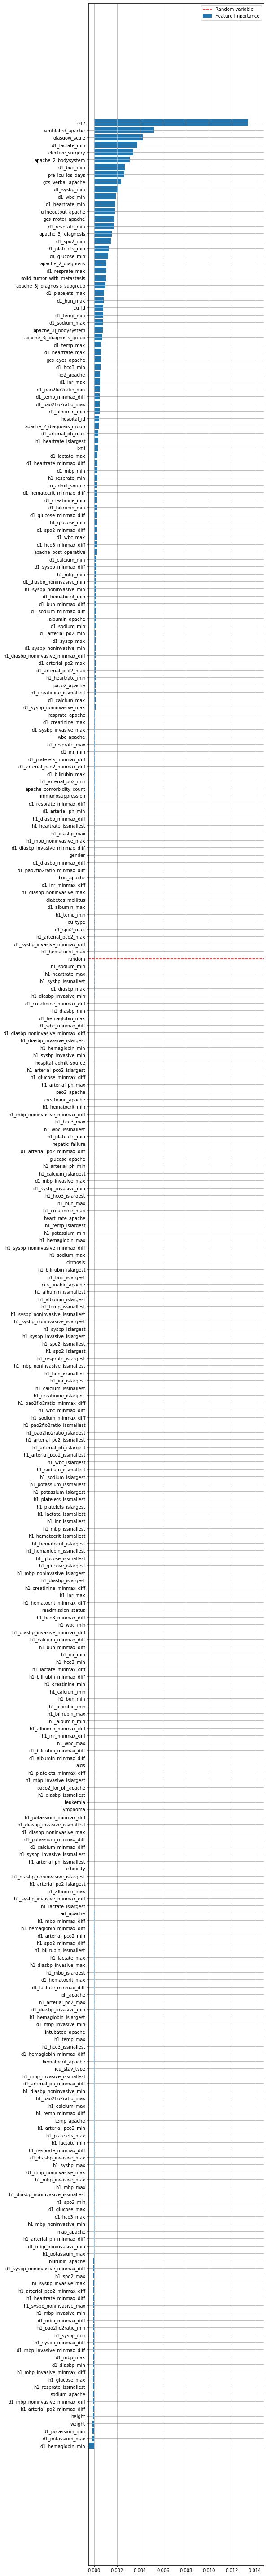

In [35]:
np.random.seed(1368)
X_train['random'] = np.random.random(size=X_train.shape[0])
X_val['random'] = np.random.random(size=X_val.shape[0])

model = LGBMClassifier(class_weight='balanced', objective='binary')
model.fit(X_train, y_train)

feat_impt = permutation_importance(model, X_val, y_val, metric_lgb_auc)
plot_feature_importance(feat_impt)

In [74]:
features = list(feat_impt['feature'].head(113))

In [82]:
features.remove('gender')

In [84]:
'gender' in features

False

#### Get test results

In [65]:
encoder = fit_label(df, cols=encoding_cols)
train_val_encoded = transform_label(df, encoder)
test_encoded = transform_label(test, encoder)

In [66]:
train_val_encoded = train_val_encoded.reset_index(drop=True)
X_train_val = train_val_encoded.drop(columns=['hospital_death', 
#                                               'apache_4a_hospital_death_prob', 
#                                               'apache_4a_icu_death_prob'
                                             ])
y_train_val = train_val_encoded[['hospital_death']]

test_encoded = test_encoded.reset_index(drop=True)
X_test = test_encoded.drop(columns=['hospital_death', 
#                                     'apache_4a_hospital_death_prob', 
#                                     'apache_4a_icu_death_prob'
                                   ])
y_test = test_encoded[['hospital_death']]

In [88]:
encoding_cols

['ethnicity',
 'gender',
 'icu_admit_source',
 'icu_id',
 'icu_stay_type',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'apache_3j_bodysystem',
 'apache_2_bodysystem',
 'apache_2_diagnosis_group',
 'apache_3j_diagnosis_subgroup',
 'apache_3j_diagnosis_group']

In [89]:
y_train_val.hospital_death.value_counts(normalize=True)

0    0.913689
1    0.086311
Name: hospital_death, dtype: float64

In [67]:
X_train_val.hospital_admit_source = X_train_val.hospital_admit_source.replace(-1, 0)
X_test.hospital_admit_source = X_test.hospital_admit_source.replace(-1, 0)

In [69]:
# model = LGBMClassifier(class_weight='balanced', objective='binary')
model = LGBModel('LightGBMBinary', 'binary', **best_params)
model.fit(X_train_val, y_train_val)

In [70]:
pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)

In [94]:
pred_proba

array([0.00324386, 0.0192386 , 0.0085466 , ..., 0.03299637, 0.00696527,
       0.07615777])

In [95]:
pd.Series(pred).value_counts(normalize=True)

0    0.967437
1    0.032563
dtype: float64

In [96]:
pred

array([0, 0, 0, ..., 0, 0, 0])

In [71]:
submission = pd.read_csv('widsdatathon2020/solution_template.csv')

In [72]:
submission['hospital_death'] = pred_proba

In [73]:
submission.to_csv('widsdatathon2020/lgbmclassifier_default.csv', index=False)